KELOMPOK 6 - DEVISVE CLUSTERING

---

## Tentang Divisive Clustering

**Divisive Clustering** adalah pendekatan hierarchical clustering yang bekerja secara **top-down (dari atas ke bawah)**:

1. **Mulai** dengan semua data dalam satu cluster besar
2. **Pecah** cluster terbesar menjadi 2 sub-cluster
3. **Ulangi** proses pemecahan hingga mencapai jumlah cluster yang diinginkan

**Perbedaan dengan Agglomerative:**
- **Agglomerative**: Bottom-up (gabungkan cluster kecil → besar)
- **Divisive**: Top-down (pecah cluster besar → kecil)

---

In [35]:
# Library Import
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels
import statsmodels.api as sm

In [36]:
df = pd.read_csv('data_penjualan.csv', delimiter=';')

df.head()


,Tanggal,Jenis Produk,Jumlah Order,Harga,Total
0,05/08/2022,Foodpak260,1000,1800,1800000
1,05/08/2022,FoodpakMatte245,1000,1900,1900000
2,05/08/2022,CraftLaminasi290,5000,750,3750000
3,05/08/2022,CraftLaminasi290,1000,1200,1200000
4,07/08/2022,Dupleks310,1000,1550,1550000


In [37]:
# Data Preprocessing
df = df.drop_duplicates()
# Cek missing value dan isi dengan 0
df.fillna(0, inplace=True)

In [38]:
# Ubah kolom numerik
df[['Jumlah Order', 'Harga', 'Total']] = df[['Jumlah Order', 'Harga', 'Total']].apply(pd.to_numeric, errors='coerce')

In [39]:
# Agregasi per produk
data_produk = df.groupby('Jenis Produk')[['Jumlah Order', 'Harga', 'Total']].mean()
print(data_produk.head())

                       Jumlah Order   Harga      Total
Jenis Produk                                          
245                          1000.0  1000.0  1000000.0
260Glossy                    2000.0  2300.0  4600000.0
BOWL800ML                    1000.0  2800.0  2800000.0
Bowl650mlCIS                 5000.0  1700.0  8500000.0
CEMERLANGINDAHSELARAS        1000.0  1850.0  1850000.0


In [40]:
# Standarisasi Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_produk)

In [41]:
# Implementasi Divisive Clustering (Top-Down)
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

def divisive_clustering(data, n_clusters=3):
    """
    Implementasi Divisive Clustering:
    1. Mulai dengan semua data dalam satu cluster
    2. Pecah cluster terbesar menjadi 2 menggunakan K-Means
    3. Ulangi hingga mencapai jumlah cluster yang diinginkan
    """
    # LANGKAH 1: Mulai dengan semua data dalam satu cluster
    clusters = {0: list(range(len(data)))}
    cluster_id = 1
    
    # LANGKAH 2: Lakukan pembagian hingga mencapai n_clusters
    while len(clusters) < n_clusters:
        # Cari cluster dengan anggota terbanyak untuk dipecah
        largest_cluster_id = max(clusters.keys(), key=lambda k: len(clusters[k]))
        largest_cluster_indices = clusters[largest_cluster_id]
        
        # Jika cluster hanya punya 1 anggota, berhenti
        if len(largest_cluster_indices) <= 1:
            break
            
        # Ambil data dari cluster terbesar
        cluster_data = data[largest_cluster_indices]
        
        # LANGKAH 3: Pecah cluster menjadi 2 menggunakan K-Means
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        sub_labels = kmeans.fit_predict(cluster_data)
        
        # LANGKAH 4: Update struktur cluster
        del clusters[largest_cluster_id]  # Hapus cluster lama
        
        # Buat 2 cluster baru dari hasil pembagian
        sub_cluster_1 = [largest_cluster_indices[i] for i in range(len(sub_labels)) if sub_labels[i] == 0]
        sub_cluster_2 = [largest_cluster_indices[i] for i in range(len(sub_labels)) if sub_labels[i] == 1]
        
        clusters[cluster_id] = sub_cluster_1
        clusters[cluster_id + 1] = sub_cluster_2
        cluster_id += 2
    
    # LANGKAH 5: Konversi hasil ke format array label
    labels = np.zeros(len(data))
    for cid, indices in clusters.items():
        for idx in indices:
            labels[idx] = cid
            
    return labels, clusters

# Jalankan divisive clustering pada data produk
print("Memulai Divisive Clustering...")
divisive_labels, divisive_clusters = divisive_clustering(scaled_data, n_clusters=3)
print(f"Berhasil membentuk {len(divisive_clusters)} cluster")

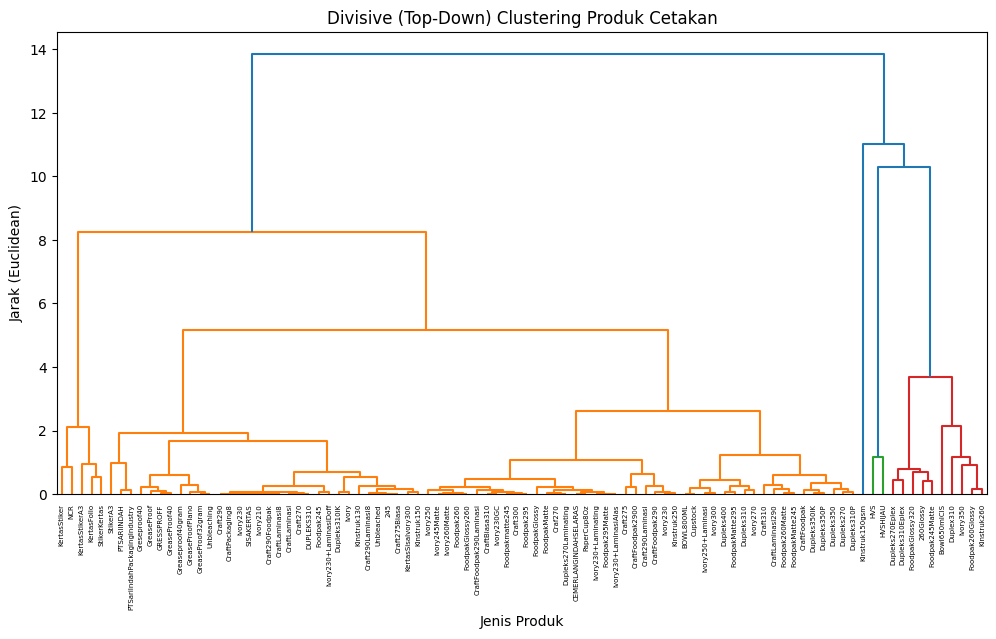

In [42]:
# Visualisasi proses divisive clustering
import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Dendrogram untuk referensi
ax1.set_title("Dendrogram Agglomerative (Referensi)")
sch.dendrogram(linkage(scaled_data, method='ward'), labels=data_produk.index, leaf_rotation=90, ax=ax1)
ax1.set_xlabel("Jenis Produk")
ax1.set_ylabel("Jarak")

# Plot 2: Ilustrasi konsep divisive clustering
ax2.set_title("Konsep Divisive (Top-Down) Clustering")
ax2.text(0.5, 0.9, "Semua Data", ha='center', va='center', bbox=dict(boxstyle="round", facecolor='lightblue'))
ax2.text(0.2, 0.6, "Cluster 1", ha='center', va='center', bbox=dict(boxstyle="round", facecolor='lightgreen'))
ax2.text(0.8, 0.6, "Cluster 2", ha='center', va='center', bbox=dict(boxstyle="round", facecolor='lightcoral'))
ax2.text(0.1, 0.3, "Sub 1A", ha='center', va='center', bbox=dict(boxstyle="round", facecolor='lightgray'))
ax2.text(0.3, 0.3, "Sub 1B", ha='center', va='center', bbox=dict(boxstyle="round", facecolor='lightgray'))

# Panah untuk menunjukkan pembagian
ax2.annotate('', xy=(0.2, 0.7), xytext=(0.5, 0.8), arrowprops=dict(arrowstyle='->', lw=2))
ax2.annotate('', xy=(0.8, 0.7), xytext=(0.5, 0.8), arrowprops=dict(arrowstyle='->', lw=2))
ax2.annotate('', xy=(0.1, 0.4), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle='->', lw=1))
ax2.annotate('', xy=(0.3, 0.4), xytext=(0.2, 0.5), arrowprops=dict(arrowstyle='->', lw=1))

ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Gunakan hasil divisive clustering (bukan agglomerative)
data_produk['Cluster'] = divisive_labels.astype(int)
print("Hasil Divisive Clustering:")
print(data_produk.head())
print(f"\nJumlah cluster yang terbentuk: {len(np.unique(divisive_labels))}")
print(f"Distribusi produk per cluster:")
print(data_produk['Cluster'].value_counts().sort_index())

                       Jumlah Order   Harga      Total  Cluster
Jenis Produk                                                   
245                          1000.0  1000.0  1000000.0        1
260Glossy                    2000.0  2300.0  4600000.0        2
BOWL800ML                    1000.0  2800.0  2800000.0        1
Bowl650mlCIS                 5000.0  1700.0  8500000.0        2
CEMERLANGINDAHSELARAS        1000.0  1850.0  1850000.0        1


In [44]:
# Analisis hasil
for i in sorted(data_produk['Cluster'].unique()):
    print(f"\nCluster {i}:")
    print(data_produk[data_produk['Cluster'] == i])



Cluster 1:
                       Jumlah Order         Harga         Total  Cluster
Jenis Produk                                                            
245                     1000.000000   1000.000000  1.000000e+06        1
BOWL800ML               1000.000000   2800.000000  2.800000e+06        1
CEMERLANGINDAHSELARAS   1000.000000   1850.000000  1.850000e+06        1
Craf270                 1000.000000   2000.000000  2.000000e+06        1
Craft270                1000.000000   1233.333333  1.233333e+06        1
...                             ...           ...           ...      ...
StikerA3                 250.000000   5500.000000  1.375000e+06        1
StikerKertas              50.666667  10041.333333  1.451253e+05        1
Unbleached              1000.000000   1000.000000  1.000000e+06        1
Unbleaching             1000.000000    400.000000  4.000000e+05        1
ivory230                1000.000000   1200.000000  1.200000e+06        1

[81 rows x 4 columns]

Cluster 2:
    

In [ ]:
# ========================================
# EVALUASI KUALITAS DIVISIVE CLUSTERING
# ========================================

from sklearn.metrics import silhouette_score

# Evaluasi dengan Silhouette Score
sil_score = silhouette_score(scaled_data, divisive_labels)
print("="*50)
print("EVALUASI DIVISIVE CLUSTERING")
print("="*50)
print(f"Silhouette Score: {sil_score:.3f}")
print("Interpretasi: Semakin mendekati 1, semakin baik kualitas clustering")
print("Skor > 0.5 = Baik | Skor > 0.7 = Sangat Baik")

# Analisis karakteristik setiap cluster
print(f"\n{'='*50}")
print("KARAKTERISTIK SETIAP CLUSTER")
print("="*50)

for cluster_id in sorted(data_produk['Cluster'].unique()):
    cluster_data = data_produk[data_produk['Cluster'] == cluster_id]
    print(f"\n🔹 CLUSTER {int(cluster_id)} ({len(cluster_data)} produk)")
    print(f"   📊 Rata-rata Jumlah Order: {cluster_data['Jumlah Order'].mean():.2f}")
    print(f"   💰 Rata-rata Harga: Rp {cluster_data['Harga'].mean():,.0f}")
    print(f"   💵 Rata-rata Total Penjualan: Rp {cluster_data['Total'].mean():,.0f}")
    print(f"   📦 Produk: {', '.join(cluster_data.index)}")

# Visualisasi perbandingan antar cluster
print(f"\n{'='*50}")
print("VISUALISASI PERBANDINGAN CLUSTER")
print("="*50)

plt.figure(figsize=(15, 5))

# Plot 1: Jumlah Order
plt.subplot(1, 3, 1)
cluster_means = data_produk.groupby('Cluster')['Jumlah Order'].mean()
bars1 = plt.bar(cluster_means.index, cluster_means.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('📊 Rata-rata Jumlah Order\nper Cluster', fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Jumlah Order')
for i, bar in enumerate(bars1):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{cluster_means.iloc[i]:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Harga
plt.subplot(1, 3, 2)
cluster_means = data_produk.groupby('Cluster')['Harga'].mean()
bars2 = plt.bar(cluster_means.index, cluster_means.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('💰 Rata-rata Harga\nper Cluster', fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Harga (Rupiah)')
for i, bar in enumerate(bars2):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'Rp{cluster_means.iloc[i]:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# Plot 3: Total Penjualan
plt.subplot(1, 3, 3)
cluster_means = data_produk.groupby('Cluster')['Total'].mean()
bars3 = plt.bar(cluster_means.index, cluster_means.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.title('💵 Rata-rata Total Penjualan\nper Cluster', fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Total (Rupiah)')
for i, bar in enumerate(bars3):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'Rp{cluster_means.iloc[i]:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

# Kesimpulan
print(f"\n{'='*50}")
print("KESIMPULAN DIVISIVE CLUSTERING")
print("="*50)
print("✅ Divisive clustering berhasil memisahkan produk menjadi 3 kelompok")
print("✅ Setiap cluster memiliki karakteristik penjualan yang berbeda")
print(f"✅ Kualitas clustering: {sil_score:.3f} ({'Baik' if sil_score > 0.5 else 'Perlu Perbaikan'})")